This tutorial is going to make use of the dataset of IMDB film reviews and aim to classify them as positive or negative.

To start off, import all the required packages:

In [1]:
#Importing tensorflow, keras and numpy
import tensorflow as tf
from tensorflow import keras

import numpy as np

Next, import the IMDB review dataset from keras:

In [2]:
#Importing IMDB dataset
imdb = keras.datasets.imdb

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

Now, taking a look at the format of the data. There are 25000 training entries total:

In [3]:
#Investigating the length of the training data
print("Training entries: {}, labels: {}".format(len(train_data), len(train_labels)))

Training entries: 25000, labels: 25000


Each review's text is rendered as numbers, each of which refers to the index of a word in a dictionary file.

In [4]:
#An example of the format of the data from the first review
print(train_data[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


As can be expected, not all reviews are of the same length; below is a comparison of the lengths of the first and second reviews:

In [5]:
#Finding lengths of the first two reviews in the dataset
len(train_data[0]), len(train_data[1])

(218, 189)

It might be useful to know what the words of the reviews were, so we can create a function that'll retrieve the words from the dictionary.

In [6]:
# A dictionary mapping words to an integer index
word_index = imdb.get_word_index()

# The first indices are reserved
word_index = {k:(v+3) for k,v in word_index.items()} 
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2  # unknown
word_index["<UNUSED>"] = 3

reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

The above creates a function called decode_review that can retrieve the text used. Here's an example of its use, decoding the first review:

In [7]:
#Retrieving text for the first review
decode_review(train_data[0])

"<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wh

To be used in a neural network, the reviews need to be converted into tensors. For this tutorial, the less memory-intensive option of padding reviews so they're all the same length then creating a tensor with the shape max_length * num_reviews.

To ensure all reviews are the same length, the pad_sequences function will be used:

In [8]:
#Pad training and test data to the same maximum length
train_data = keras.preprocessing.sequence.pad_sequences(train_data,
                                                        value=word_index["<PAD>"],
                                                        padding='post',
                                                        maxlen=256)

test_data = keras.preprocessing.sequence.pad_sequences(test_data,
                                                       value=word_index["<PAD>"],
                                                       padding='post',
                                                       maxlen=256)

Comparing the first and second review lengths again now shows them to be the same length, as expected:

In [9]:
#Comparing lengths of first two reviews again now they've been padded
len(train_data[0]), len(train_data[1])

(256, 256)

The padded reviews will display a string of zeroes to fill up the "missing" space, as can be seen in the padded version of the first review:

In [10]:
print(train_data[0])

[   1   14   22   16   43  530  973 1622 1385   65  458 4468   66 3941
    4  173   36  256    5   25  100   43  838  112   50  670    2    9
   35  480  284    5  150    4  172  112  167    2  336  385   39    4
  172 4536 1111   17  546   38   13  447    4  192   50   16    6  147
 2025   19   14   22    4 1920 4613  469    4   22   71   87   12   16
   43  530   38   76   15   13 1247    4   22   17  515   17   12   16
  626   18    2    5   62  386   12    8  316    8  106    5    4 2223
 5244   16  480   66 3785   33    4  130   12   16   38  619    5   25
  124   51   36  135   48   25 1415   33    6   22   12  215   28   77
   52    5   14  407   16   82    2    8    4  107  117 5952   15  256
    4    2    7 3766    5  723   36   71   43  530  476   26  400  317
   46    7    4    2 1029   13  104   88    4  381   15  297   98   32
 2071   56   26  141    6  194 7486   18    4  226   22   21  134  476
   26  480    5  144   30 5535   18   51   36   28  224   92   25  104
    4 

And, just for the hell of it, here's the text for it this time:

In [11]:
#Retrieving text for the first review
decode_review(train_data[0])

"<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wh

So any padded entries are registered as PAD, to distinguish them from words which are just too rare to be included in the dictionary, which are UNK.

Now it's time to actually build the model. This needs decisions on the number of layers and number of hidden units for each layer. These will be kept as in the tutorial example first, and potentially fiddled with later.

In [12]:
# input shape is the vocabulary count used for the movie reviews (10,000 words)
vocab_size = 10000

#Building the model; here we see an embedding layer, a pooling layer, and two dense layers
#One dense layer has 16 hidden units, and the other has just one and produces the output - either 0 or 1
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 16))
model.add(keras.layers.GlobalAveragePooling1D())
model.add(keras.layers.Dense(16, activation=tf.nn.relu))
model.add(keras.layers.Dense(1, activation=tf.nn.sigmoid))

#Details of the model
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 160,289
Trainable params: 160,289
Non-trainable params: 0
_________________________________________________________________


Now, select an optimiser and loss function for the model; here, binary crossentropy was chosen to be the best for this type of problem

In [13]:
#Setting the optimiser and loss function
model.compile(optimizer=tf.train.AdamOptimizer(),
              loss='binary_crossentropy',
              metrics=['accuracy'])

For testing purposes, it can be useful to have a validation set, which lets us know how accurate the model is for data it hasn't seen before. This is separate from the test dataset, as that's only meant to be used after training is finished, while this is for during training.

Generate a validation set by setting aside 10000 reviews from the original training dataset:

In [14]:
#Separating a subsection of reviews to use for validation
x_val = train_data[:10000]
partial_x_train = train_data[10000:]

y_val = train_labels[:10000]
partial_y_train = train_labels[10000:]

Now, we can actually train the model. The tutorial's defaults are to train over 40 epochs in mini-batches which have 512 samples. The loss and accuracy are found using the validation set.

In [15]:
#Train and produce information for loss and accuracy with each epoch
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Train on 15000 samples, validate on 10000 samples
Epoch 1/40
15000/15000 [==============================] - 4s 276us/step - loss: 0.6923 - acc: 0.5593 - val_loss: 0.6910 - val_acc: 0.5848
Epoch 2/40
15000/15000 [==============================] - 3s 224us/step - loss: 0.6882 - acc: 0.6577 - val_loss: 0.6852 - val_acc: 0.7456
Epoch 3/40
15000/15000 [==============================] - 3s 209us/step - loss: 0.6784 - acc: 0.7353 - val_loss: 0.6721 - val_acc: 0.7228
Epoch 4/40
15000/15000 [==============================] - 3s 206us/step - loss: 0.6586 - acc: 0.7638 - val_loss: 0.6493 - val_acc: 0.7341
Epoch 5/40
15000/15000 [==============================] - 3s 201us/step - loss: 0.6271 - acc: 0.7807 - val_loss: 0.6147 - val_acc: 0.7774
Epoch 6/40
15000/15000 [==============================] - 3s 199us/step - loss: 0.5853 - acc: 0.8067 - val_loss: 0.5736 - val_acc: 0.8046
Epoch 7/40
15000/15000 [==============================] - 3s 206us/step - loss: 0.5376 - acc: 0.8289 - val_loss: 0.5297 - 

Before I move on with the tutorial stuff, gotta say I think it started overfitting on the first run - the validation dataset really slows down on accuracy after about the 20th epoch and by the 25th is barely changing at all, while the training accuracy keeps going up and up. This may be officially commented on in the tutorial soon, but those're my thoughts having just run it.

Okay, now that the model's been trained, we can test it on the test dataset. Here, in order, we're going to see loss and accuracy.

In [16]:
results = model.evaluate(test_data, test_labels)

print(results)

25000/25000 [==============================] - 1s 55us/step
[0.3283825603103638, 0.87272]


The results here are just slightly worse than the validation set, and significantly worse than the training set, which isn't really that surprising with the overfitting spotted before. That said, overall it's a reasonable level of accuracy - it's just not as accurate as with reviews it's already seen.

To examine how loss and accuracy vary, we can graph them using the information from the history object.

In [17]:
#Getting information from history
history_dict = history.history
history_dict.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

The entries from this are the accuracy and loss from the training and validation sets. Time to do some plotting.

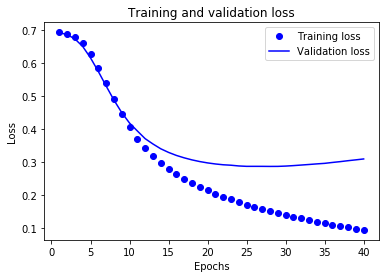

In [20]:
#Setting up matplotlib to plot
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

#Starting off by plotting loss
#Incidentally, keeping the original comments where they were broke the graph
plt.plot(epochs, loss, 'bo', label='Training loss') # "bo" is for "blue dot"
plt.plot(epochs, val_loss, 'b', label='Validation loss')  #b is for "solid blue line"
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

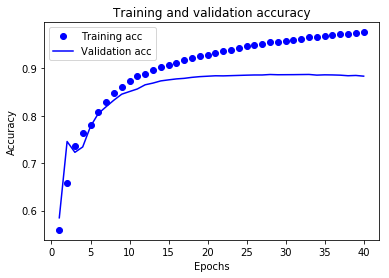

In [19]:
#This time, plot accuracy
plt.clf()   # clear figure
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

As I commented earlier, these show overfitting - both the loss and accuracy level off somewhere around the 20 epoch mark while the training set keeps on improving, so really there's not much point continuing to fit beyond about the 20 epoch mark.